<a href="https://colab.research.google.com/github/robertferro/previsao_plano_saude/blob/main/previsao_fumante.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Previsão se o cliente é fumante ou não.

O objetivo deste projeto é prever se um determinado cliente do plano de saúde é fumante ou não, visto que o fato de ser fumante implica diretamente nos custos do cliente.

Um cliente que nega ser fumante ao aderir ao plano, pode significar uma perda significativa, logo ser bem assertivo e capturar maior número de registros ao fazer essa previsão é de fundamental importância na hora de calcular o valor do plano para clientes fumantes e não fumantes.

O projeto foi dividido em 4 partes, sendo elas:

##1. Carregamento dos dados
  - Incluicarregar as bibliotecas que serão ultilizadas.
  - Carregar a base de dados e uma primira análise.

##2. EDA(Análise exploratória dos dados)
  - Por meio de gráficos tentar extrais alguns insights.
  - Analisar a correlação entre as variáveis e a variável target.

##3. Machine Learning
 
- Divisão do dataset em treino, teste e validação.
- Fazer o pré-processamento dos dados:
  - Tratamento de missing values.
  - Encodding de variáveis categóricas.
- Criar uma baseline.
- Seleção do algoritmo de machine learning.
- Tunagem e validação do modelo por meio de validação cruzada.
- Verificar a performance do modelo, usando métricas como F1-score, precision e recall.

##4. Avalição da amostra de validação
  - Aplicar Transformações nos dados de validação
  - Ajustar o modelos aos dados de treino e teste
  - Fazer as previsões na amostra de validação
  - Avaliar a performance do modelo na amostra de validação.

##5. Salvando o modelo
  - Usar piclke para salvar o modelo e colocar em produção.

##6. Deploy do modelo
  - Etapa feita fora do Notebook.
  - O melhor modelo foi colocado em produção usando o **framework streamlit** do python e hospedado na nuvem, podendo ser acessado pelo link:

   https://previsaoplanofumante.herokuapp.com/

### **Ao final o melhor algoritmo escolhido foi XGBoostClassifier, com Precisão de 88%, que significa que quando o modelo diz ser fumante, a cada 100 pessoas que o modelo classifica como fumante, ele acerta 88, e sensibilidade de 96%, que significa que o modelo consegue capturar 96% dos registros de pessoas fumantes de toda a base de dados**

#1. Carregamento dos dados



In [1]:
# filtro de warnings
import warnings
warnings.filterwarnings("ignore")

# carregamento dos dados
import pandas as pd

# maniplaão e visualização dos dados
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# divisão treino e teste, validação
from sklearn.model_selection import train_test_split,cross_val_score

# métricas de avaliação do modelo
from sklearn.metrics import  roc_auc_score,roc_curve, classification_report, confusion_matrix
from sklearn import metrics
from sklearn.model_selection import RepeatedKFold
# from numpy import absolute

# baseline
from sklearn.dummy import DummyClassifier

# importando modelos de machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# salvar o modelo
import pickle

In [2]:
url='https://raw.githubusercontent.com/robertferro/previsao_plano_saude/main/dados_plano.csv'
dados = pd.read_csv(url)
dados.head()

,Idade,Sexo,IMC,Filhos,Fumante,Regiao,Custos
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
# verificando informações do dataset
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Idade    1338 non-null   int64  
 1   Sexo     1338 non-null   object 
 2   IMC      1338 non-null   float64
 3   Filhos   1338 non-null   int64  
 4   Fumante  1338 non-null   object 
 5   Regiao   1338 non-null   object 
 6   Custos   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


O dataset não apresenta missing values, mas será preciso ser feito algumas transformações nos dados, já que existem variáveis categóricas.

#2. EDA

Análise exploratória dos dados


In [4]:
dados.describe()

,Idade,IMC,Filhos,Custos
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


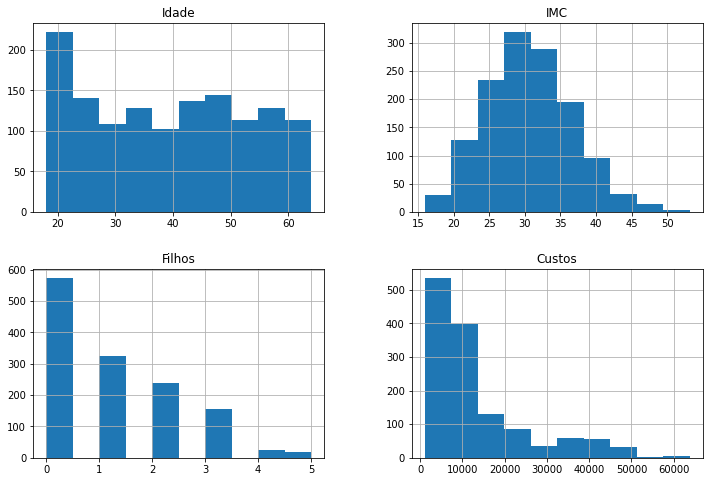

In [5]:
dados.hist(figsize=(12,8));

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


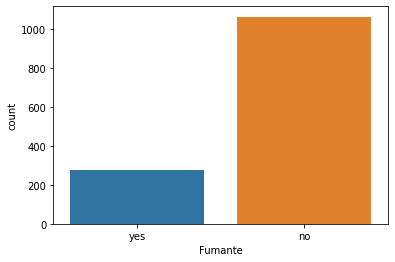

In [6]:
sns.countplot('Fumante',data=dados);

Analisando o dataset. podem ser feitas algumas considerações:

-  A variável custos possui desvio padrão alto, o que indica dados dispersos que irão precisar passar por algum tipo de tratamento.
- 75% dos registros tem custo inferior ou igual a 16639.912515
- Os dados estão bem distribuídos, exceto com relação a variável alvo "Fumante" e "Filhos", que  estão desbalanceadas.

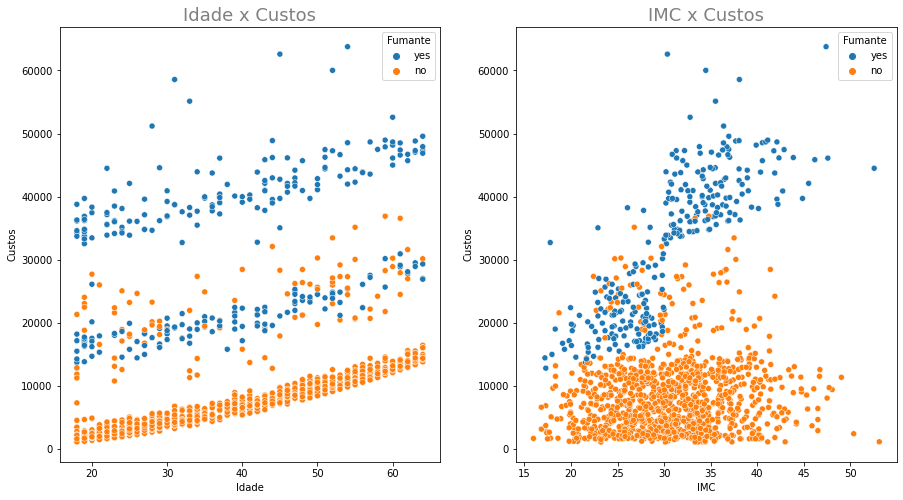

In [7]:
# analisando a relação entre Custos ,IMC e Idade.
fig,ax = plt.subplots(1,2, figsize=(15,8))
# gráfico
sns.scatterplot(x='Idade',y='Custos',data=dados,hue='Fumante', ax=ax[0]);
# Inclusição do Titulo
ax[0].set_title('Idade x Custos', loc='center', fontsize=18, color='gray');

# gráfico
sns.scatterplot(x='IMC',y='Custos',data=dados,hue='Fumante', ax=ax[1]);
# Inclusição do Titulo
ax[1].set_title('IMC x Custos', loc='center', fontsize=18, color='gray');

**Insights**

Pessoas fumantes tem custos bem mais elevados do que quem não fuma, podendo chegar a uma diferença de até 10x mais dependendo da faixa etária ou do IMC.

Quanto maior o IMC de pessoas fumantes, maiores os custos.

Para pessoas não fumantes o IMC não influencia tanto nos custos.

Conforme a idade avança os custos tendem a subir.

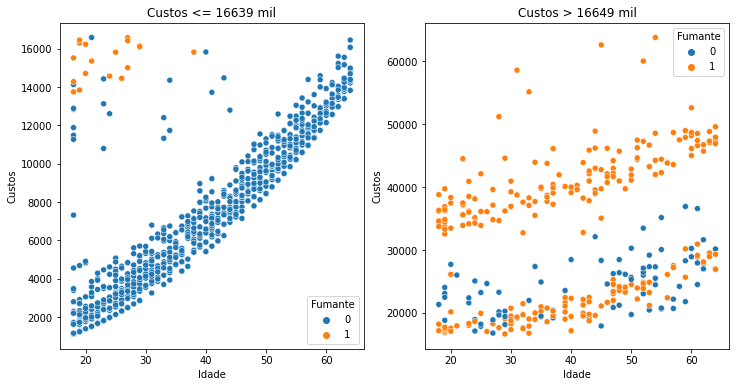

In [39]:
# 
fig,ax = plt.subplots(1,2, figsize=(12,6))
sns.scatterplot(y='Custos',x='Idade',data=dados[dados['Custos']<=16639.912515],hue='Fumante',ax=ax[0])
ax[0].set_title('Custos <= 16639 mil');

sns.scatterplot(y='Custos',x='Idade',data=dados[dados['Custos']>16639.912515],hue='Fumante',ax=ax[1]);
ax[1].set_title('Custos > 16649 mil');

Análises:

- Fica mais evidente que para custos abaixo de 16639 mil, pessoas não fumantes tem uma relação idade x custos de maneira linear,contendo alguns outliers.
- Para custos abaixo de 16639existem pouquíssimas pessoas nã fumantes.
- Pessoas não fumantes se concentram com custos abaixo de 12 mil, independentemente da idade.
- O fato de ser Fumante ou não pode elevar até em 10X os custos.
- Quando os custos são superiores a 16639 mil, a maioria dos registros são de possoas fumantes.

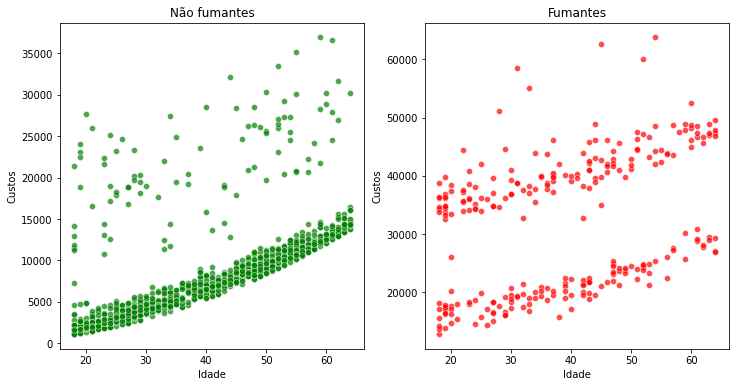

In [40]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
sns.scatterplot(y='Custos',x='Idade',data=dados[dados['Fumante']==0], ax=ax[0],color='g',alpha=0.7);
ax[0].set_title('Não fumantes')

sns.scatterplot(y='Custos',x='Idade',data=dados[dados['Fumante']==1], ax=ax[1],color='r', alpha=0.7);
ax[1].set_title('Fumantes');

In [12]:
# transformando a variável alvo em numérica
dados['Fumante'] = np.where(dados['Fumante']=="yes",1,0)
dados.head()

,Idade,Sexo,IMC,Filhos,Fumante,Regiao,Custos
0,19,female,27.900,0,1,southwest,16884.92400
1,18,male,33.770,1,0,southeast,1725.55230
2,28,male,33.000,3,0,southeast,4449.46200
3,33,male,22.705,0,0,northwest,21984.47061
4,32,male,28.880,0,0,northwest,3866.85520


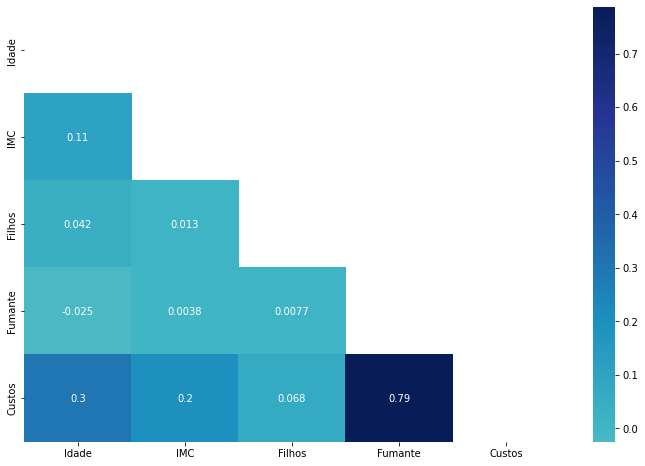

In [13]:
plt.figure(figsize=(12,8))

corr = dados.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))

sns.heatmap(corr, mask=mask, annot=True, center=0, cmap="YlGnBu")

plt.show()

Idade e Custo tem uma correlação positiva de 0.3, o que indica que os custos tendem a aumentar de acordo com a idade.

Fumante e Custos tem correlação positiva de 0.79, forte, que indica a condição de ser fumante ou não implica diretamente nos custos.

O IMC também exerce influência no custo, já que esse é um índice que diz se a pessoa está ou não dentro do peso recomendado, o que pode implicar em seu estado de saúde e consequentemente nos custos.

#3. Machine Learning
 
- Divisão do dataset em treino, teste e validação.

- Fazer o pré-processamento dos dados:
  - Tratamento de missing values.
  - Encodding de variáveis categóricas.

- Seleção do modelo:
  - Criar uma baseline.

  - Escolha de um modelo

  - Tunagem, validação e avaliação do modelo escolhido

- Previsões para amostra de validação
  - Avalição da amostra de validação

## 3.1  Divisão do dataset em treino, teste e validação.

In [15]:
# separando uma amostra para validação
dados_ml = dados[:1000]
dados_validacao = dados[1000:]

# divisão em X(Features) e Y(Target)
X = dados_ml.drop('Fumante',axis=1)
Y = dados_ml['Fumante']

# divisão em treino e teste

X_treino, X_teste, Y_treino, Y_teste = train_test_split(X,Y, test_size=0.2 ,stratify=Y)

In [16]:
X_treino.head()

,Idade,Sexo,IMC,Filhos,Regiao,Custos
486,54,female,21.47,3,northwest,12475.3513
191,36,female,26.20,0,southwest,4883.8660
903,49,male,36.85,0,southeast,8125.7845
762,33,male,27.10,1,southwest,19040.8760
502,51,male,23.21,1,southeast,22218.1149


In [17]:
X_teste.head()

,Idade,Sexo,IMC,Filhos,Regiao,Custos
117,29,female,27.94,1,southeast,19107.7796
421,61,male,35.86,0,southeast,46599.1084
943,19,male,22.61,0,northwest,1628.4709
635,64,male,38.19,0,northeast,14410.9321
933,45,female,35.30,0,southwest,7348.1420


In [18]:
dados_validacao.head()

,Idade,Sexo,IMC,Filhos,Fumante,Regiao,Custos
1000,30,male,22.99,2,1,northwest,17361.76610
1001,24,male,32.70,0,1,southwest,34472.84100
1002,24,male,25.80,0,0,southwest,1972.95000
1003,48,male,29.60,0,0,southwest,21232.18226
1004,47,male,19.19,1,0,northeast,8627.54110


##3.2 Pré-processamento dos dados 
Tranformando variáveis categóricas em variáveis numéricas.

Varificando e tratando a presença de outliers.

In [19]:
# transformando os dados de treino

dic_sexo = {'male':0,
           'female':1}

dic_regiao = {'southwest':0, 'southeast':1, 'northwest':2, 'northeast':3}

X_treino['Sexo'] = X_treino['Sexo'].map(dic_sexo)

X_treino['Regiao'] = X_treino['Regiao'].map(dic_regiao)

X_treino.head()

,Idade,Sexo,IMC,Filhos,Regiao,Custos
486,54,1,21.47,3,2,12475.3513
191,36,1,26.20,0,0,4883.8660
903,49,0,36.85,0,1,8125.7845
762,33,0,27.10,1,0,19040.8760
502,51,0,23.21,1,1,22218.1149


In [20]:
# transformando os dados de teste

dic_sexo = {'male':0,
           'female':1}

dic_regiao = {'southwest':0, 'southeast':1, 'northwest':2, 'northeast':3}

X_teste['Sexo'] = X_teste['Sexo'].map(dic_sexo)

X_teste['Regiao'] = X_teste['Regiao'].map(dic_regiao)

X_teste.head()

,Idade,Sexo,IMC,Filhos,Regiao,Custos
117,29,1,27.94,1,1,19107.7796
421,61,0,35.86,0,1,46599.1084
943,19,0,22.61,0,2,1628.4709
635,64,0,38.19,0,3,14410.9321
933,45,1,35.30,0,0,7348.1420


- Verificando a presença de outliers.


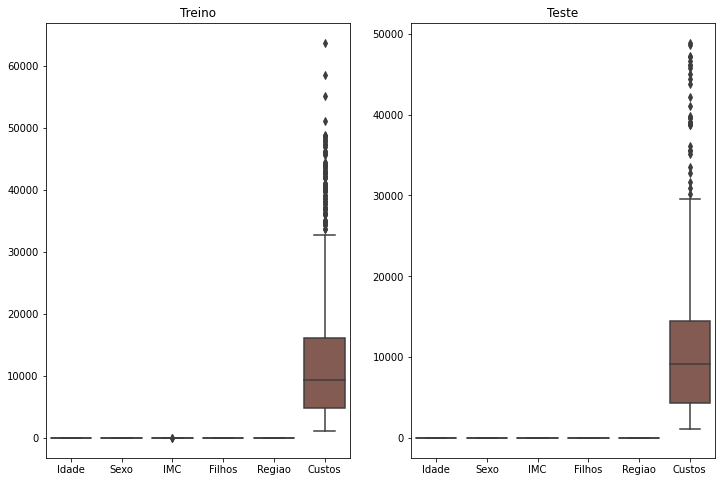

In [21]:
fig,ax = plt.subplots(1,2, figsize=(12,8))
sns.boxplot(data=X_treino, ax=ax[0])
ax[0].set_title('Treino')
sns.boxplot(data=X_teste,ax=ax[1]);
ax[1].set_title('Teste');

Analisando o boxplot, podem ser observados a presença de alguns outliers na variável **Custos**. 

Os dados serã normalizados para remover esse ruído.

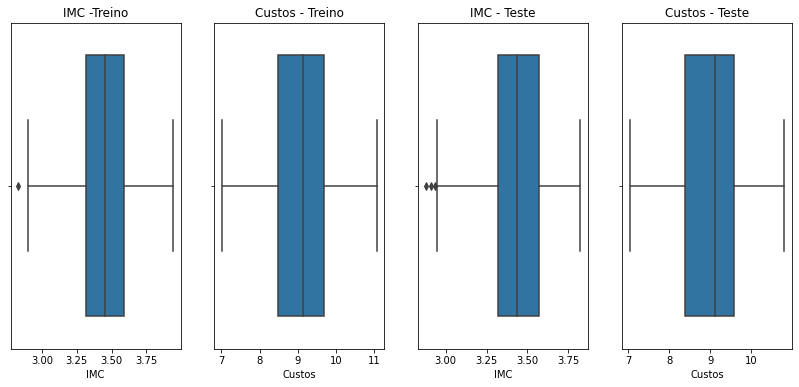

In [22]:
fig,ax = plt.subplots(1,4, figsize=(14,6))
sns.boxplot(x='IMC',data = np.log1p(X_treino),ax=ax[0])
ax[0].set_title('IMC -Treino')
sns.boxplot(x='Custos',data = np.log1p(X_treino),ax=ax[1])
ax[1].set_title('Custos - Treino');

sns.boxplot(x='IMC',data = np.log1p(X_teste),ax=ax[2])
ax[2].set_title('IMC - Teste')
sns.boxplot(x='Custos',data = np.log1p(X_teste),ax=ax[3]);
ax[3].set_title('Custos - Teste');

Após sar a transformação oraritmica para normalizar os dados, pode-se observar que os outliers existem apenas na variável **IMC**.

In [23]:
# transformando os dados de treino e teste

X_treino_log = np.log1p(X_treino)
X_teste_log = np.log1p(X_teste)

X_treino_log.head()

,Idade,Sexo,IMC,Filhos,Regiao,Custos
486,4.007333,0.693147,3.112181,1.386294,1.098612,9.431590
191,3.610918,0.693147,3.303217,0.000000,0.000000,8.493897
903,3.912023,0.000000,3.633631,0.000000,0.693147,9.002921
762,3.526361,0.000000,3.335770,0.693147,0.000000,9.854396
502,3.951244,0.000000,3.186766,0.693147,0.693147,10.008708


##3.3 Seleção do modelo

A acurácia do dummy mostfrequent foi 80.50%

ROC AUC:  0.5

              precision    recall  f1-score   support

           0       0.81      1.00      0.89       161
           1       0.00      0.00      0.00        39

    accuracy                           0.81       200
   macro avg       0.40      0.50      0.45       200
weighted avg       0.65      0.81      0.72       200




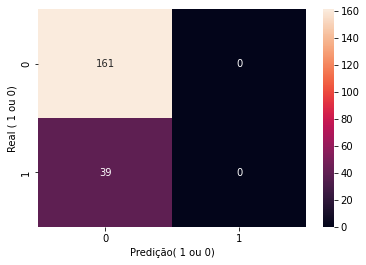

In [24]:
# instanciando o modelo
dummy_clf = DummyClassifier(strategy="most_frequent")

# ajustando o modelo aos dados de treino
dummy_clf.fit(X_treino_log, Y_treino)

# fazendo as previsões para os dados de teste
y_pred = dummy_clf.predict(X_teste_log)

# calculando a acurácia do modelo para os dados de teste
acuracia = dummy_clf.score(X_teste_log, Y_teste) * 100

# exibindo a acurácia
print('A acurácia do dummy mostfrequent foi %.2f%%' % acuracia)
print()

# calculando o y_proba
y_proba = dummy_clf.predict_proba(X_teste_log)
# Valor da curva roc
print(f'ROC AUC: ',roc_auc_score(Y_teste, y_proba[:,1]))
print()

# gerando clasifications report contendo métricas como precision,recall
print(classification_report(Y_teste, y_pred))
print()

# gerando a matriz de confusão
cm=confusion_matrix(Y_teste, y_pred)
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predição( 1 ou 0)')
plt.ylabel('Real ( 1 ou 0)')
plt.show()


- Como ponto de partida peguei o modelo acima, que obteve acurácia 80,5%

- Analisando outros modelos

In [25]:
# lsita com alguns classificadores
lista_classificacores = [ LogisticRegression(),
                         GaussianNB(),
                         DecisionTreeClassifier(),
                         RandomForestClassifier(),
                         XGBClassifier()]

# criando um loop para medir a performance dos classificadores
for clf in lista_classificacores:
  print(clf.__class__.__name__)
  clf.fit(X_treino, Y_treino)
  train_acc = clf.score(X_treino_log, Y_treino)
  val_score = cross_val_score(clf, X_treino_log, Y_treino, cv=10)
  test_acc = clf.score(X_teste_log, Y_teste)
  print('Treino:', train_acc)
  print('Validation score', val_score.mean())
  print('Teste:', test_acc)

  print('ROC AUC')

  y_proba_treino = clf.predict_proba(X_treino_log)
  roc_treino = roc_auc_score(Y_treino, y_proba_treino[:, 1])
  print('Treino', roc_treino)

  y_proba_teste = clf.predict_proba(X_teste_log)
  roc_teste = roc_auc_score(Y_teste, y_proba_teste[:, 1])
  print('Test', roc_teste)
  print('='*60)

LogisticRegression
Treino: 0.19625
Validation score 0.9625
Teste: 0.195
ROC AUC
Treino 0.5241354716644708
Test 0.462494027711419
GaussianNB
Treino: 0.80375
Validation score 0.9087500000000001
Teste: 0.805
ROC AUC
Treino 0.5551505185684144
Test 0.5954769867813345
DecisionTreeClassifier
Treino: 0.80375
Validation score 0.96125
Teste: 0.805
ROC AUC
Treino 0.5
Test 0.5
RandomForestClassifier
Treino: 0.80375
Validation score 0.95875
Teste: 0.805
ROC AUC
Treino 0.4798516111777001
Test 0.43876413441630835
XGBClassifier
Treino: 0.80375
Validation score 0.9537500000000001
Teste: 0.805
ROC AUC
Treino 0.5400491327475706
Test 0.5942028985507246


### Melhor modelo: XGBClassifier

O modelo que melhor performou e que obteve maior score de valiação foi o XGBClassifier.


A acurácia do XGBCLassifier foi 98.50%

ROC AUC : 0.9909221213569039



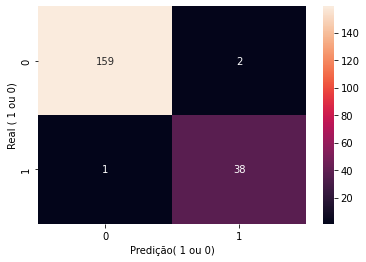


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       161
           1       0.95      0.97      0.96        39

    accuracy                           0.98       200
   macro avg       0.97      0.98      0.98       200
weighted avg       0.99      0.98      0.99       200




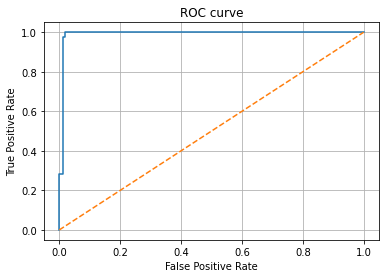

In [26]:
# tunando o modelo
clf = XGBClassifier(max_depth=18,n_estimators=300,learning_rate=0.056,seed=42)

# ajustando o modelo
clf.fit(X_treino, Y_treino)

# previsoes
y_pred = clf.predict(X_teste)
# probabilidades
y_proba = clf.predict_proba(X_teste)


# acurácia
acuracia = clf.score(X_teste, Y_teste) * 100
print('A acurácia do XGBCLassifier foi %.2f%%' % acuracia)
print()


# calculando ROC AUC  Score
roc_auc = roc_auc_score(Y_teste, y_proba[:,1])
print('ROC AUC :',roc_auc)
print()


# matriz de confusão
cm=confusion_matrix(Y_teste, y_proba[:,1]>0.5)
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predição( 1 ou 0)')
plt.ylabel('Real ( 1 ou 0)')
plt.show()
print()

print(classification_report(Y_teste, y_proba[:,1]>0.5))
print()

fpr, tpr, thresholds = metrics.roc_curve(Y_teste,y_proba[:,1])
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], '--')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()


#4. Avaliando o modelo nos  dados de validacao

In [27]:
# concatenando os dados de treino e teste para ajustar o modleo a eles e ter melhor performance nos dados de validação
X_ajuste = pd.concat([X_treino_log,X_teste_log])
y_ajuste = pd.concat([Y_treino,Y_teste],axis=0)

In [28]:
# verificando a performance do modelo usando o RepeatedKFold para todos os dados de Treino e Teste.

clf = XGBClassifier(max_depth=18,n_estimators=300,learning_rate=0.056,seed=42)

# clf = DecisionTreeClassifier(min_samples_leaf=15 ,random_state=42)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(clf, X_ajuste,y_ajuste, scoring='f1', cv=cv, n_jobs=-1)
scores = scores
print(f'F1 score: ',scores.mean())

F1 score:  0.9193544071143965


In [29]:
# transformando os dados de validação
dados_validacao_ml = dados_validacao.copy()
dic_sexo = {'male':0,
           'female':1}

dic_regiao = {'southwest':0, 'southeast':1, 'northwest':2, 'northeast':3}

dados_validacao_ml['Sexo'] = dados_validacao_ml['Sexo'].map(dic_sexo)

dados_validacao_ml['Regiao'] = dados_validacao_ml['Regiao'].map(dic_regiao)


# divisão em X e Y - Dados de validação
Xval = dados_validacao_ml.drop('Fumante',axis=1)
Yval = dados_validacao_ml['Fumante']

# aplicando a transformação logarítmica nos dados de entrada da validação
Xval = np.log1p(Xval)

# exibindo Xval
Xval.head()

,Idade,Sexo,IMC,Filhos,Regiao,Custos
1000,3.433987,0.0,3.177637,1.098612,1.098612,9.762083
1001,3.218876,0.0,3.517498,0.000000,0.000000,10.447956
1002,3.218876,0.0,3.288402,0.000000,0.000000,7.587792
1003,3.891820,0.0,3.421000,0.000000,0.000000,9.963320
1004,3.871201,0.0,3.005187,0.693147,1.386294,9.062831


A acurácia do XGBCLassifier nos dados de validação foi 96.15%

ROC AUC : 0.9900887573964496



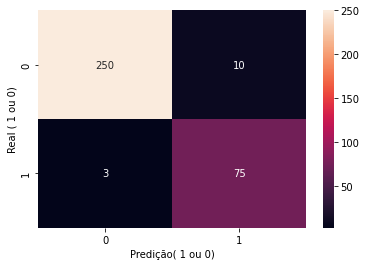


              precision    recall  f1-score   support

           0       0.99      0.96      0.97       260
           1       0.88      0.96      0.92        78

    accuracy                           0.96       338
   macro avg       0.94      0.96      0.95       338
weighted avg       0.96      0.96      0.96       338




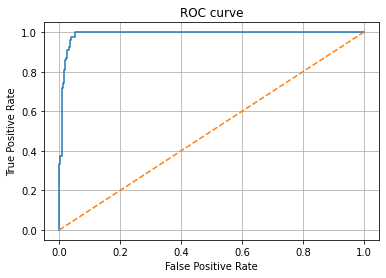

In [30]:
# ajustando o modelo aos dados de treino e teste
clf.fit(X_ajuste,y_ajuste)

# previsoes
y_pred = clf.predict(Xval)
# probabilidades
y_proba = clf.predict_proba(Xval)


# acurácia
acuracia = clf.score(Xval, Yval) * 100
print('A acurácia do XGBCLassifier nos dados de validação foi %.2f%%' % acuracia)
print()


# calculando ROC AUC  Score
roc_auc = roc_auc_score(Yval, y_proba[:,1])
print('ROC AUC :',roc_auc)
print()


# matriz de confusão
cm=confusion_matrix(Yval, y_proba[:,1]>0.5)
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predição( 1 ou 0)')
plt.ylabel('Real ( 1 ou 0)')
plt.show()
print()

print(classification_report(Yval, y_proba[:,1]>0.5))
print()

fpr, tpr, thresholds = metrics.roc_curve(Yval,y_proba[:,1])
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], '--')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

# Salvando o modelo

In [31]:
output = open('best_model', 'wb')
pickle.dump(clf, output)
output.close()

In [35]:
dados[dados['Fumante']==1].head(10)

,Idade,Sexo,IMC,Filhos,Fumante,Regiao,Custos
0,19,female,27.90,0,1,southwest,16884.92400
11,62,female,26.29,0,1,southeast,27808.72510
14,27,male,42.13,0,1,southeast,39611.75770
19,30,male,35.30,0,1,southwest,36837.46700
23,34,female,31.92,1,1,northeast,37701.87680
29,31,male,36.30,2,1,southwest,38711.00000
30,22,male,35.60,0,1,southwest,35585.57600
34,28,male,36.40,1,1,southwest,51194.55914
38,35,male,36.67,1,1,northeast,39774.27630
39,60,male,39.90,0,1,southwest,48173.36100
